In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import datetime
from datetime import timedelta, date

In [2]:
cd C:\Users\danny\AB Data Scientist TakeHome\DLG_INC_B&M_Data

C:\Users\danny\AB Data Scientist TakeHome\DLG_INC_B&M_Data


In [3]:
features = pd.read_csv('Features data set.csv')
stores = pd.read_csv('stores data-set.csv')
train = pd.read_csv('Historic sales data-set.csv')
train.Date = pd.to_datetime(train.Date)

Create the test_data csv (year of 2012 - first half of 2013)


In [4]:
# Create Test data csv - 2012 - first half of 2013

condition = (train['IsHoliday'] == True)
grouped = train[condition].reset_index()
holiday_list = set(grouped.Date.dt.strftime('%m-%d')) # Holiday = True


cols = ['Store','Dept','Date','IsHoliday']
lst = []
start_date = datetime.date(2012, 1, 6)
end_date = datetime.date(2013, 6, 30)
delta = datetime.timedelta(days=7)
dt = []

while start_date <= end_date:
    dt.append(start_date)
    start_date += delta
    

dept = 0
store = 0
x = 0
#for x in range(53):
for i in range(1,46):

        for j in range(1,99):

            for x in range(78):
                if dt[x].strftime('%m-%d') in holiday_list:
                        lst.append([i,j,dt[x], True])
                else:
                        lst.append([i,j,dt[x], False])


#df['s_date'] = [pd.date_range(datetime(2021, 5, 25, 0, 0),datetime(2021, 5, 29, 0, 0),freq='d')] 
df_test = pd.DataFrame(lst, columns = cols)
df_test
df_test.to_csv('test_dataset.csv',index= False)  #SAVE THE file as csv.format

Load the Dataset

In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [7]:
features['Date'] = features['Date'].apply(pd.to_datetime)

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [9]:
features.isnull().sum().sort_values(ascending=False).to_frame() / len(features)

,0
MarkDown2,0.643346
MarkDown4,0.577045
MarkDown3,0.558852
MarkDown1,0.507692
MarkDown5,0.505495
Unemployment,0.071429
CPI,0.071429
IsHoliday,0.000000
Fuel_Price,0.000000
Temperature,0.000000


In [10]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [11]:
print(f"Min Date value: {min(features['Date'])}")
print(f"\nMax Date value: {max(features['Date'])}")

Min Date value: 2010-01-10 00:00:00

Max Date value: 2013-12-07 00:00:00


In [12]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [13]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [14]:
stores.isnull().sum().sort_values(ascending=False).to_frame() / len(stores)

,0
Size,0.0
Type,0.0
Store,0.0


In [15]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [16]:
stores['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

In [17]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [18]:
train['Date'] = train['Date'].apply(pd.to_datetime)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294132 entries, 0 to 294131
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         294132 non-null  int64         
 1   Dept          294132 non-null  int64         
 2   Date          294132 non-null  datetime64[ns]
 3   Weekly_Sales  294132 non-null  float64       
 4   IsHoliday     294132 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 9.3 MB


In [20]:
train.isnull().sum().sort_values(ascending=False).to_frame() / len(train)

,0
IsHoliday,0.0
Weekly_Sales,0.0
Date,0.0
Dept,0.0
Store,0.0


In [21]:
train.describe()

,Store,Dept,Weekly_Sales
count,294132.000000,294132.000000,294132.000000
mean,22.180178,44.184135,16105.306895
std,12.780170,30.430023,22961.301005
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2146.025000
50%,22.000000,37.000000,7727.310000
75%,33.000000,72.000000,20356.665000
max,45.000000,99.000000,693099.360000


<h1>Exploratory Data Analysis<h1>
    <h2>Holidays<h2>
    check if there are more non-holiday days than the number of holidays.


C:\Users\danny\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


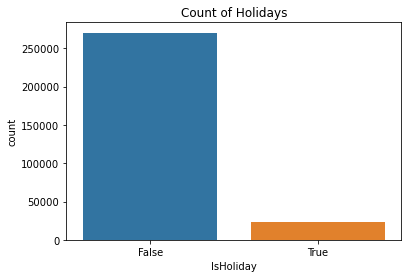

In [22]:
train['IsHoliday'].value_counts()
plt.title('Count of Holidays')
sns.countplot(train['IsHoliday'])
plt.show()

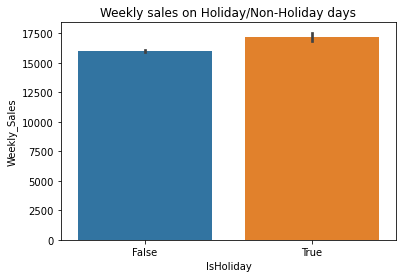

Average weekly_sales on a Holiday weekend is : 17175.66
Average weekly_sales on a non Holiday weekend is : 16011.53
Observation: It can be seen that sales is higher on holidays


In [23]:
plt.title("Weekly sales on Holiday/Non-Holiday days")
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=train)
plt.show()
print("Average weekly_sales on a Holiday weekend is : {:.2f}". format(np.mean(train['Weekly_Sales'][(train['IsHoliday']==True)])))
print("Average weekly_sales on a non Holiday weekend is : {:.2f}". format(np.mean(train['Weekly_Sales'][(train['IsHoliday']==False)])))
print("Observation: It can be seen that sales is higher on holidays")

C:\Users\danny\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


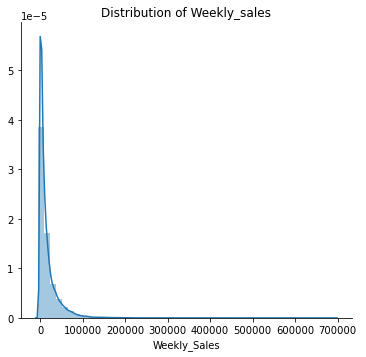

Observation: Most sales are between 10k - 45k.


In [24]:
sns.FacetGrid(train, height=5).map(sns.distplot, "Weekly_Sales").add_legend();
plt.title("Distribution of Weekly_sales")
plt.show()

print('Observation: Most sales are between 10k - 45k.')

In [25]:
train.loc[train['Weekly_Sales']>600000]


,Store,Dept,Date,Weekly_Sales,IsHoliday
66689,10,72,2010-11-26,693099.36,True
66741,10,72,2011-11-25,630999.19,True
236107,35,72,2010-11-26,627962.93,True
236159,35,72,2011-11-25,649770.18,True


Observation: Hihgest weekly sales might be during the holidays - Thanksgiving day

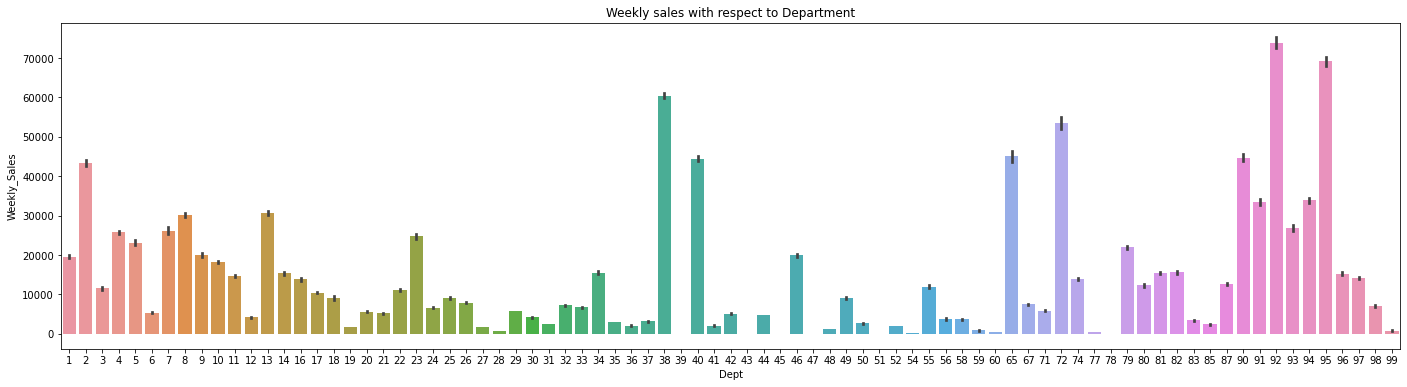

In [26]:
plt.figure(figsize=(24,6))
plt.title("Weekly sales with respect to Department")
sns.barplot(x='Dept', y='Weekly_Sales', data=train)
plt.show()

In [27]:
train['Weekly_Sales'].loc[train['Dept'] == 92].sum()


332313900.89

Observation = Dept 92 shows the highest weekly sales  $332313900.89000005

In [28]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False
...,...,...,...,...,...
294127,45,98,2011-02-12,538.51,False
294128,45,98,2011-09-12,572.72,False
294129,45,98,2011-12-16,853.46,False
294130,45,98,2011-12-23,1084.78,False


In [29]:
db_train = train.groupby(['Store', 'Dept'])['Dept'].count().to_frame().rename(columns={'Dept':'count'})
db_train.reset_index(inplace=True)

In [30]:
db_train['Store'].value_counts().to_frame().sort_index()

,Store
1,77
2,78
3,71
4,78
5,72
6,77
7,75
8,75
9,72
10,77


In [31]:
# merge/concat the train and store dataset
db_train_store = pd.merge(left=train, right=stores, on='Store', how='left')
db_train_store.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-05-02,24924.50,False,A,151315
1,1,1,2010-12-02,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-05-03,21827.90,False,A,151315


In [34]:
#db_train_store_g = db_train_store.groupby(['Date', 'Type'])['Weekly_Sales'].sum().reset_index()
#db_train_store_g.index = db_train_store_g['Date']

In [35]:
#merge/concat train_stores & features
db_train_store_features = pd.merge(left=db_train_store, right=features, on=['Store', 'Date'], how='left', suffixes=('_train', '_features'))
db_train_store_features.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features
0,1,1,2010-05-02,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-12-02,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-05-03,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [36]:
db_train_store_features.Type = db_train_store_features.Type.map({'A':1, 'B':2, 'C':3})

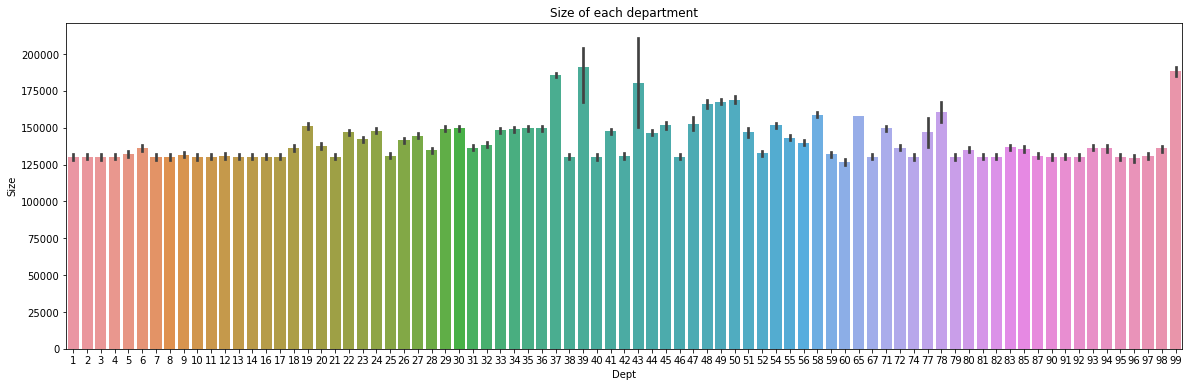

In [37]:
plt.figure(figsize=(20,6))
plt.title("Size of each department")
sns.barplot(x='Dept', y='Size', data=db_train_store)
plt.show()

Observation:
1. There is no significant difference in store size(almost equal).
2. However, Store 39,37,99 has recorded highest weekly salarly.
3. Store size is not proportional to the weekly sales.

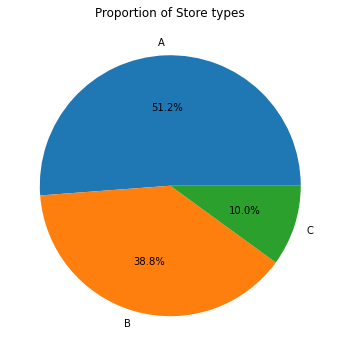

In [38]:
sums = db_train_store['Type'].value_counts()
plt.figure(figsize=(20,6))
plt.title("Proportion of Store types")
plt.pie(sums, labels=sums.index,autopct='%1.1f%%');
plt.show()

Observation:
1. Type A stores show the largest proportion.

<AxesSubplot:title={'center':'Weekly_sales based on Type of stores'}, xlabel='Type', ylabel='Weekly_Sales'>

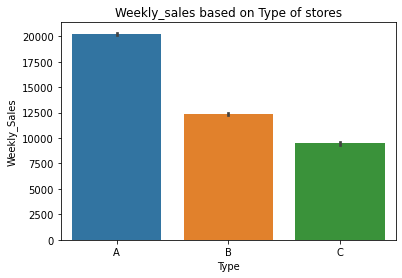

In [39]:
plt.title("Weekly_sales based on Type of stores")
sns.barplot(x='Type', y='Weekly_Sales', data=db_train_store)

Observation:
1. Weekly sales are directly proportional to the number of store types.
2. Type A stores show the highest weekly sales.
3. Type C stores show the lowest weekly sales.

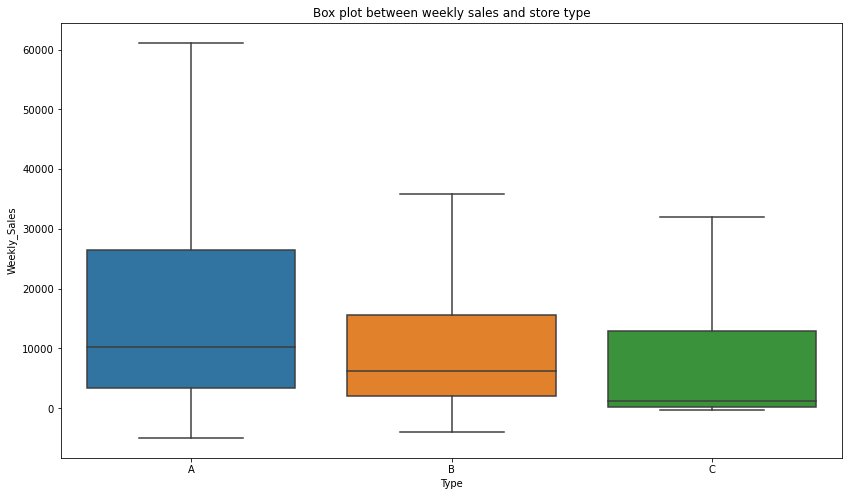

In [40]:
plt.figure(figsize=(14,8))
plt.title("Box plot between weekly sales and store type")
sns.boxplot(x='Type', y='Weekly_Sales',data=db_train_store,showfliers=False)
plt.show()

Observation:
1. As can be seen from the boxplot, it can be seen that type A store records higher weekly sales  than other types of stores and at the same time has a higher median value.

Next, Check the correlation between each features.


In [41]:
db_train_store_features

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features
0,1,1,2010-05-02,24924.50,False,1,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-12-02,46039.49,True,1,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,1,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,1,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-05-03,21827.90,False,1,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294127,45,98,2011-02-12,538.51,False,2,118221,50.19,3.452,6835.61,120.76,802.79,2490.15,17861.50,188.502435,8.523,False
294128,45,98,2011-09-12,572.72,False,2,118221,46.57,3.415,6176.69,2.87,379.57,1593.44,10170.50,188.654469,8.523,False
294129,45,98,2011-12-16,853.46,False,2,118221,39.93,3.413,4631.26,8.92,801.34,848.33,2757.82,188.797935,8.523,False
294130,45,98,2011-12-23,1084.78,False,2,118221,42.27,3.389,797.10,89.14,1962.19,17.00,2985.51,188.929975,8.523,False


<h2>Correlations between the features in dataset.</h2>

<AxesSubplot:>

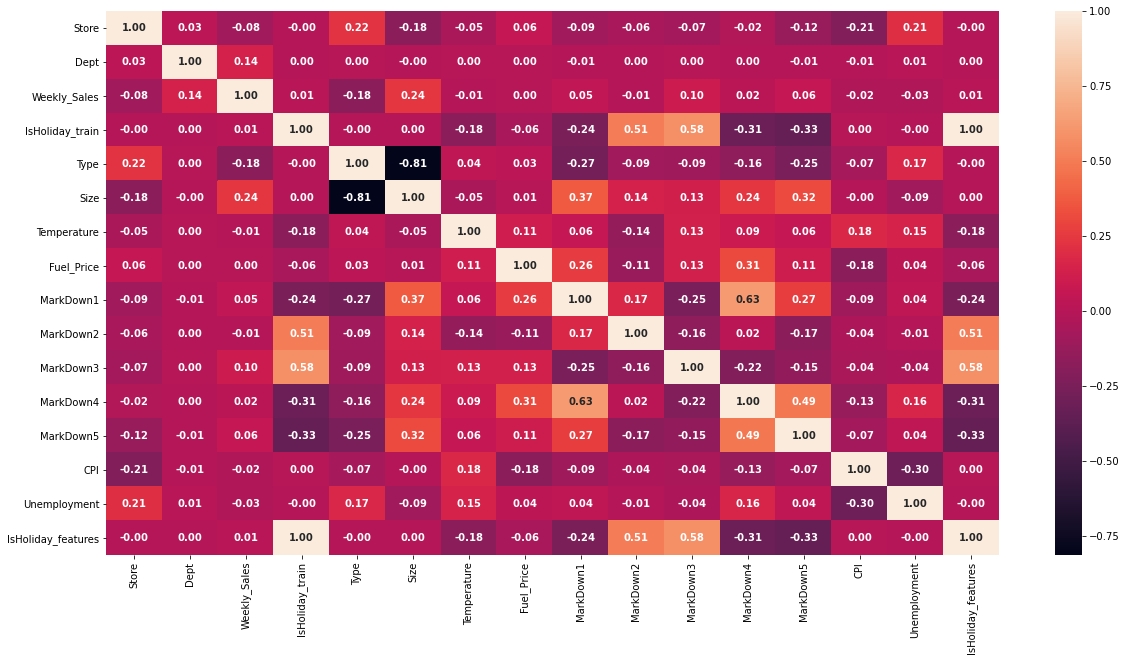

In [42]:
plt.figure(figsize=(20,10))
sns.heatmap(
    db_train_store_features.corr(), 
    annot=db_train_store_features.corr(), 
    fmt='.2f', 
    annot_kws={'fontsize':10, 'fontweight':'bold'}
)

In [43]:
db_train_store_features

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features
0,1,1,2010-05-02,24924.50,False,1,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-12-02,46039.49,True,1,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,1,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,1,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-05-03,21827.90,False,1,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294127,45,98,2011-02-12,538.51,False,2,118221,50.19,3.452,6835.61,120.76,802.79,2490.15,17861.50,188.502435,8.523,False
294128,45,98,2011-09-12,572.72,False,2,118221,46.57,3.415,6176.69,2.87,379.57,1593.44,10170.50,188.654469,8.523,False
294129,45,98,2011-12-16,853.46,False,2,118221,39.93,3.413,4631.26,8.92,801.34,848.33,2757.82,188.797935,8.523,False
294130,45,98,2011-12-23,1084.78,False,2,118221,42.27,3.389,797.10,89.14,1962.19,17.00,2985.51,188.929975,8.523,False


In [44]:
#Converting the string type to pandas date_time
#Add the week of year, month start, month end
db_train_store_features['Date']=pd.to_datetime(db_train_store_features.Date)  
 
db_train_store_features['Year']=pd.DatetimeIndex(db_train_store_features['Date']).year  
db_train_store_features['Month']=pd.DatetimeIndex(db_train_store_features['Date']).month
db_train_store_features['Day']=pd.DatetimeIndex(db_train_store_features['Date']).day
db_train_store_features['Day_of_year']=pd.DatetimeIndex(db_train_store_features['Date']).dayofyear
db_train_store_features['Week_of_year']=pd.DatetimeIndex(db_train_store_features['Date']).weekofyear
db_train_store_features['Month_start']=pd.DatetimeIndex(db_train_store_features['Date']).is_month_start
db_train_store_features['Month_end']=pd.DatetimeIndex(db_train_store_features['Date']).is_month_end

<ipython-input-44-deb3b607cad9>:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  db_train_store_features['Week_of_year']=pd.DatetimeIndex(db_train_store_features['Date']).weekofyear


In [45]:
db_train_store_features

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,...,CPI,Unemployment,IsHoliday_features,Year,Month,Day,Day_of_year,Week_of_year,Month_start,Month_end
0,1,1,2010-05-02,24924.50,False,1,151315,42.31,2.572,NaN,...,211.096358,8.106,False,2010,5,2,122,17,False,False
1,1,1,2010-12-02,46039.49,True,1,151315,38.51,2.548,NaN,...,211.242170,8.106,True,2010,12,2,336,48,False,False
2,1,1,2010-02-19,41595.55,False,1,151315,39.93,2.514,NaN,...,211.289143,8.106,False,2010,2,19,50,7,False,False
3,1,1,2010-02-26,19403.54,False,1,151315,46.63,2.561,NaN,...,211.319643,8.106,False,2010,2,26,57,8,False,False
4,1,1,2010-05-03,21827.90,False,1,151315,46.50,2.625,NaN,...,211.350143,8.106,False,2010,5,3,123,18,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294127,45,98,2011-02-12,538.51,False,2,118221,50.19,3.452,6835.61,...,188.502435,8.523,False,2011,2,12,43,6,False,False
294128,45,98,2011-09-12,572.72,False,2,118221,46.57,3.415,6176.69,...,188.654469,8.523,False,2011,9,12,255,37,False,False
294129,45,98,2011-12-16,853.46,False,2,118221,39.93,3.413,4631.26,...,188.797935,8.523,False,2011,12,16,350,50,False,False
294130,45,98,2011-12-23,1084.78,False,2,118221,42.27,3.389,797.10,...,188.929975,8.523,False,2011,12,23,357,51,False,False


In [46]:
import math
db_train_store_features['week_in_month'] = pd.to_numeric(db_train_store_features.Day/7)
db_train_store_features['week_in_month'] = db_train_store_features['week_in_month'].apply(lambda x: math.ceil(x))
db_train_store_features

,Store,Dept,Date,Weekly_Sales,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,...,Unemployment,IsHoliday_features,Year,Month,Day,Day_of_year,Week_of_year,Month_start,Month_end,week_in_month
0,1,1,2010-05-02,24924.50,False,1,151315,42.31,2.572,NaN,...,8.106,False,2010,5,2,122,17,False,False,1
1,1,1,2010-12-02,46039.49,True,1,151315,38.51,2.548,NaN,...,8.106,True,2010,12,2,336,48,False,False,1
2,1,1,2010-02-19,41595.55,False,1,151315,39.93,2.514,NaN,...,8.106,False,2010,2,19,50,7,False,False,3
3,1,1,2010-02-26,19403.54,False,1,151315,46.63,2.561,NaN,...,8.106,False,2010,2,26,57,8,False,False,4
4,1,1,2010-05-03,21827.90,False,1,151315,46.50,2.625,NaN,...,8.106,False,2010,5,3,123,18,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294127,45,98,2011-02-12,538.51,False,2,118221,50.19,3.452,6835.61,...,8.523,False,2011,2,12,43,6,False,False,2
294128,45,98,2011-09-12,572.72,False,2,118221,46.57,3.415,6176.69,...,8.523,False,2011,9,12,255,37,False,False,2
294129,45,98,2011-12-16,853.46,False,2,118221,39.93,3.413,4631.26,...,8.523,False,2011,12,16,350,50,False,False,3
294130,45,98,2011-12-23,1084.78,False,2,118221,42.27,3.389,797.10,...,8.523,False,2011,12,23,357,51,False,False,4


C:\Users\danny\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Sales Each year'}, xlabel='Year', ylabel='Weekly_Sales'>

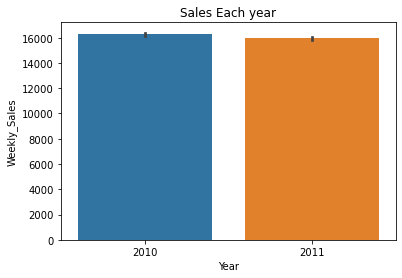

In [47]:
plt.title("Sales Each year")
sns.barplot(db_train_store_features['Year'], db_train_store_features['Weekly_Sales'])


Observation:
1. There is no sifnificant difference between 2010 and 2011.

<AxesSubplot:title={'center':'Sales based on each week'}, xlabel='Week_of_year', ylabel='Weekly_Sales'>

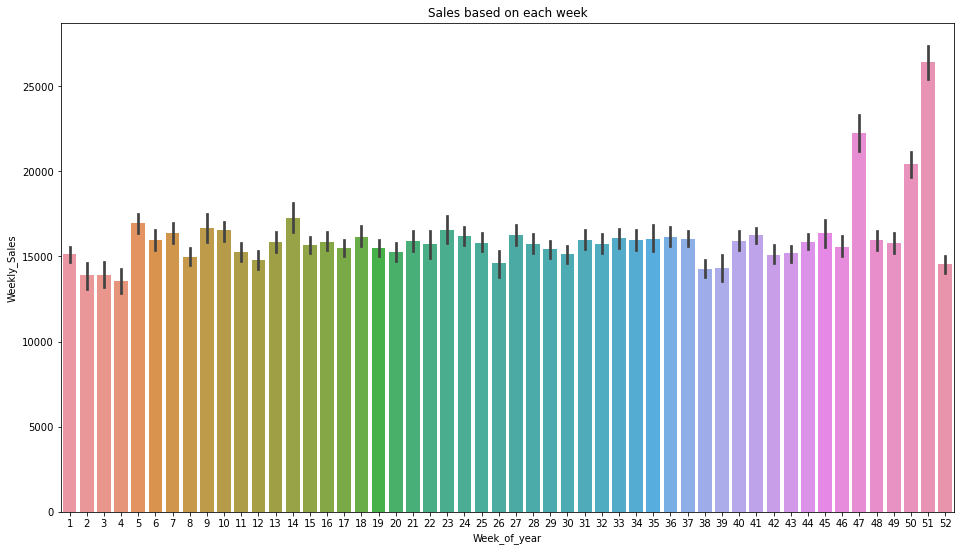

In [48]:
plt.figure(figsize=(16,9))
plt.title("Sales based on each week")
sns.barplot(x='Week_of_year', y='Weekly_Sales',data=db_train_store_features)

Observation:
    1. Sales are high on Thanksgiving and the end of the year.(Christmas)

C:\Users\danny\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


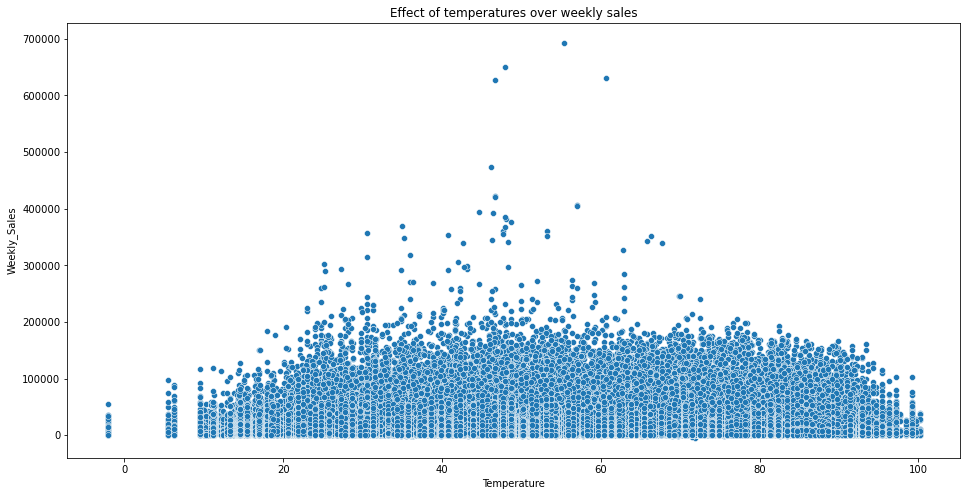

In [49]:
plt.figure(figsize=(16,8))
sns.scatterplot(db_train_store_features['Temperature'], db_train_store_features['Weekly_Sales'])
plt.title("Effect of temperatures over weekly sales")
plt.show()

Obersvation:
1. Sales has an slightly affect in lower temp and temp > 90 degrees

<AxesSubplot:xlabel='Month', ylabel='Temperature'>

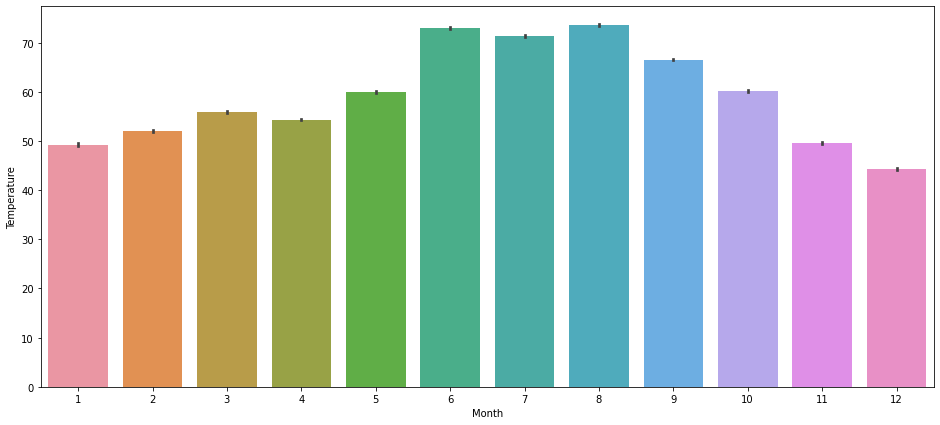

In [50]:
plt.figure(figsize=(16,7))
sns.barplot(x='Month', y='Temperature',data=db_train_store_features)


<AxesSubplot:xlabel='Year', ylabel='Temperature'>

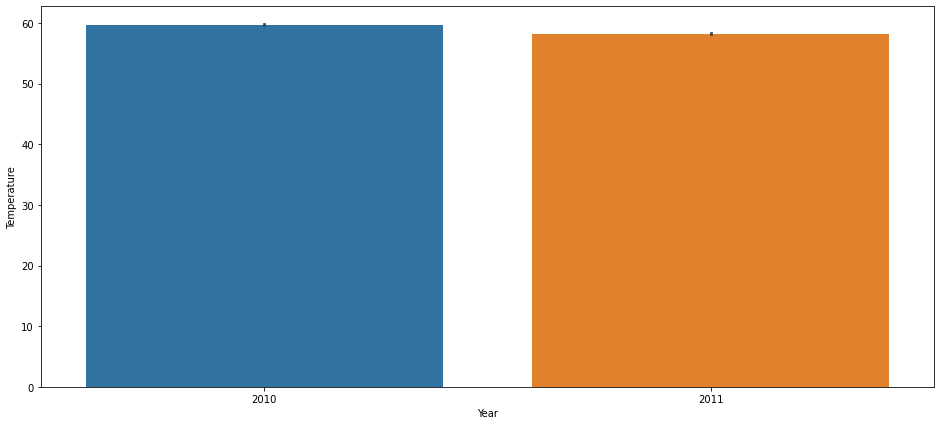

In [51]:
plt.figure(figsize=(16,7))
sns.barplot(x='Year', y='Temperature',data=db_train_store_features)

Unemployment check

<AxesSubplot:title={'center':'Unemployment index in each month'}, xlabel='Month', ylabel='Unemployment'>

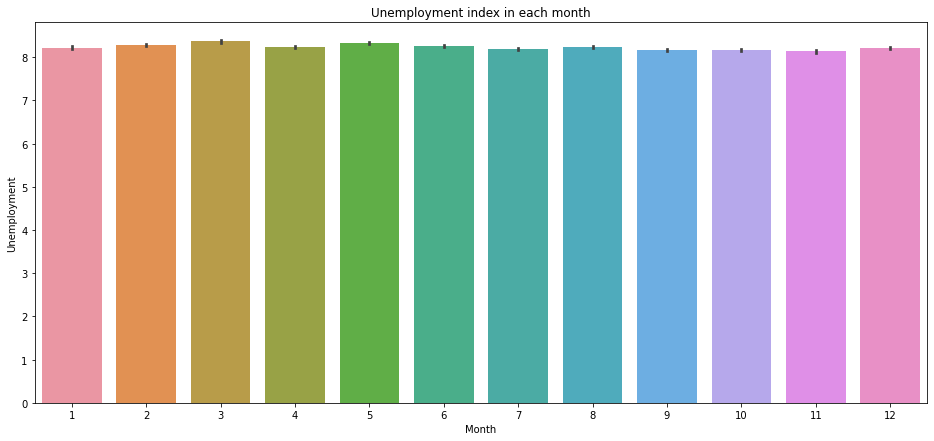

In [52]:
plt.figure(figsize=(16,7))
plt.title("Unemployment index in each month")
sns.barplot(x='Month', y='Unemployment',data=db_train_store_features)

Obersvation:
1. Since there are no sifnificant difference between unemployment and sales, weekely sales are not affected by unemployment

Check the Fuel Prices features over weekly sales

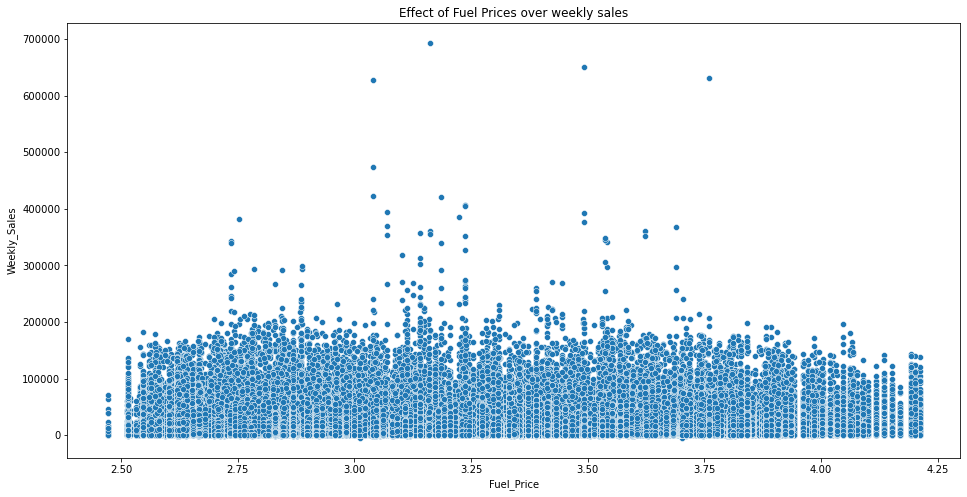

In [53]:
plt.figure(figsize=(16,8))
sns.scatterplot(data = db_train_store_features, x = 'Fuel_Price', y = 'Weekly_Sales')
plt.title("Effect of Fuel Prices over weekly sales")
plt.show()

<AxesSubplot:title={'center':'Fuel prices in each month'}, xlabel='Month', ylabel='Fuel_Price'>

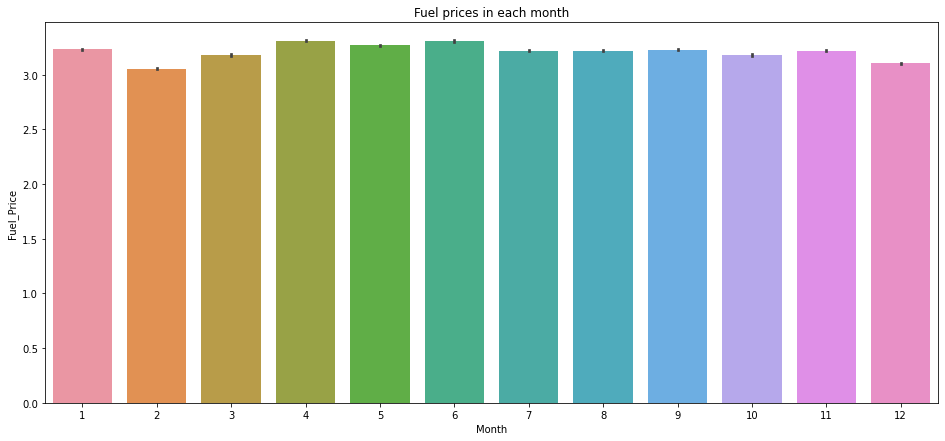

In [54]:
plt.figure(figsize=(16,7))
plt.title("Fuel prices in each month")
sns.barplot(x='Month', y='Fuel_Price',data=db_train_store_features)

In [55]:
print("Avg sales of all the stores when the Fuel price is >3.25 :",(np.mean(db_train_store_features['Weekly_Sales'][db_train_store_features['Fuel_Price']>3.25].tolist())))
print("Avg sales of all the stores when the Fuel price is <3.25 :", (np.mean(db_train_store_features['Weekly_Sales'][db_train_store_features['Fuel_Price']<3.25].tolist())))

Avg sales of all the stores when the Fuel price is >3.25 : 16020.417347513127
Avg sales of all the stores when the Fuel price is <3.25 : 16171.933082412479


It seems there are no sigginifiant relationships between fuel prices and weekly sales.
There is no difference in sales when the fuel pirce is less than or greater than $3.25.

Effect of CPI over weekly sales

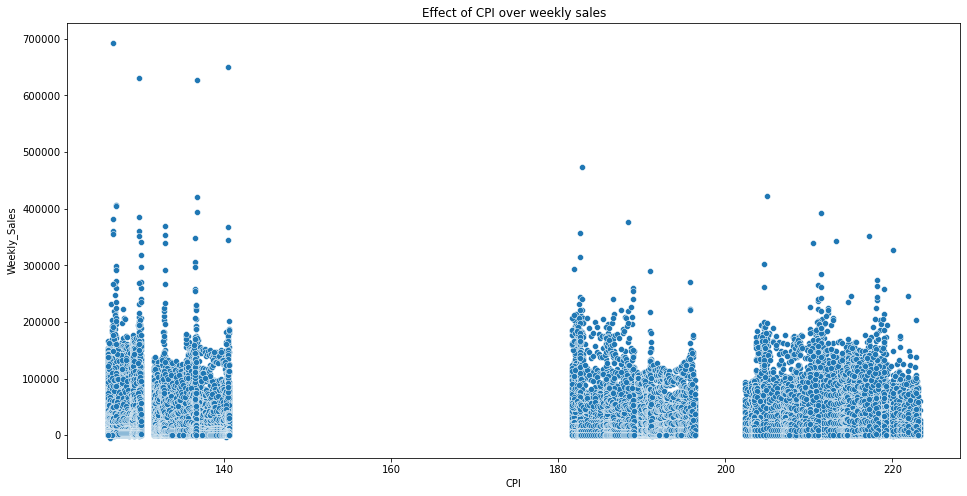

In [57]:
plt.figure(figsize=(16,8))
sns.scatterplot(x = db_train_store_features['CPI'], y = db_train_store_features['Weekly_Sales'], data = db_train_store_features)
plt.title("Effect of CPI over weekly sales")
plt.show()

There is no continuous data on CPI & no observed data between approx. 145 - 182.

<h2>Modeling</h2>

Evaluation Metrics
To evluate the models, there three metrics will be used in this part.
1. WMAE(Weighted mean absolute error)
2. MSE (Mean Squared Error)
3. MAE (Mean Absolute Error)

In [58]:
def wmae(db, y, y_h):
    weights = db.IsHoliday_train.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(y-y_h))/(np.sum(weights)), 2)

In [59]:
#X_train = db_train_store_features[['Store','Dept','Temperature','IsHoliday_train','Size', 'Type']]
#Y_train = db_train_store_features['Weekly_Sales']

In [60]:
db_train_store_features['week'] = db_train_store_features['Date'].dt.week
db_train_store_features['month'] = db_train_store_features['Date'].dt.month
db_train_store_features['day_year'] = db_train_store_features['Date'].dt.dayofyear

<ipython-input-60-06a7f5212287>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  db_train_store_features['week'] = db_train_store_features['Date'].dt.week


In [61]:
X_train = db_train_store_features[['Store','Dept','Temperature','IsHoliday_train','Size', 'Type', 'week', 'month', 'day_year']]
Y_train = db_train_store_features['Weekly_Sales']

In [62]:
db_test = pd.read_csv('test_dataset.csv')
db_test.Date = pd.to_datetime(db_test.Date)
features.Date = pd.to_datetime(features.Date)

In [63]:
db_test_store = pd.merge(left=db_test, right=stores, on='Store', how='left' )
db_test_store.head()

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-01-06,False,A,151315
1,1,1,2012-01-13,False,A,151315
2,1,1,2012-01-20,False,A,151315
3,1,1,2012-01-27,False,A,151315
4,1,1,2012-02-03,False,A,151315


In [64]:
db_test.Date = db_test.Date.apply(pd.to_datetime)

In [65]:
db_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343980 entries, 0 to 343979
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      343980 non-null  int64         
 1   Dept       343980 non-null  int64         
 2   Date       343980 non-null  datetime64[ns]
 3   IsHoliday  343980 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2)
memory usage: 8.2 MB


In [66]:
db_test_store = pd.merge(left=db_test, right=stores, on='Store', how='left' )
db_test_store.Date = pd.to_datetime(db_test_store.Date)
db_test_store.head()

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-01-06,False,A,151315
1,1,1,2012-01-13,False,A,151315
2,1,1,2012-01-20,False,A,151315
3,1,1,2012-01-27,False,A,151315
4,1,1,2012-02-03,False,A,151315


In [67]:
#-- merging dbs
db_test_store_features = pd.merge(left=db_test_store, right=features, on=['Store', 'Date'], how='left', suffixes=('_train', '_features'))

db_test_store_features.head()

,Store,Dept,Date,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features
0,1,1,2012-01-06,False,A,151315,77.95,3.501,6086.21,12.00,370.51,148.75,3690.85,221.747214,7.143,False
1,1,1,2012-01-13,False,A,151315,48.53,3.261,5183.29,8025.87,42.24,453.08,3719.38,219.892526,7.348,False
2,1,1,2012-01-20,False,A,151315,54.11,3.268,4139.87,2807.19,33.88,500.62,3400.21,219.985689,7.348,False
3,1,1,2012-01-27,False,A,151315,54.26,3.290,1164.46,1082.74,44.00,11.00,1222.19,220.078852,7.348,False
4,1,1,2012-02-03,False,A,151315,60.96,3.630,15441.40,1569.00,10.80,25390.88,8067.61,220.848045,7.348,False


In [68]:
db_test_store_features.Type = db_test_store_features.Type.map({'A':1, 'B':2, 'C':3})

In [69]:
db_test_store_features['week'] = db_test_store_features['Date'].dt.week
db_test_store_features['month'] = db_test_store_features['Date'].dt.month
db_test_store_features['day_year'] = db_test_store_features['Date'].dt.dayofyear

<ipython-input-69-c471c8d14531>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  db_test_store_features['week'] = db_test_store_features['Date'].dt.week


In [70]:
db_test_store_features

,Store,Dept,Date,IsHoliday_train,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_features,week,month,day_year
0,1,1,2012-01-06,False,1,151315,77.95,3.501,6086.21,12.00,370.51,148.75,3690.85,221.747214,7.143,False,1,1,6
1,1,1,2012-01-13,False,1,151315,48.53,3.261,5183.29,8025.87,42.24,453.08,3719.38,219.892526,7.348,False,2,1,13
2,1,1,2012-01-20,False,1,151315,54.11,3.268,4139.87,2807.19,33.88,500.62,3400.21,219.985689,7.348,False,3,1,20
3,1,1,2012-01-27,False,1,151315,54.26,3.290,1164.46,1082.74,44.00,11.00,1222.19,220.078852,7.348,False,4,1,27
4,1,1,2012-02-03,False,1,151315,60.96,3.630,15441.40,1569.00,10.80,25390.88,8067.61,220.848045,7.348,False,5,2,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343975,45,98,2013-05-31,False,2,118221,65.88,3.646,6474.49,411.38,77.06,9.38,4227.27,NaN,NaN,False,22,5,151
343976,45,98,2013-06-07,False,2,118221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,6,158
343977,45,98,2013-06-14,False,2,118221,70.01,3.632,2471.44,517.87,348.54,2612.33,3459.39,NaN,NaN,False,24,6,165
343978,45,98,2013-06-21,False,2,118221,70.13,3.626,4989.34,385.31,178.56,2463.42,3117.94,NaN,NaN,False,25,6,172


In [71]:
X_test = db_test_store_features[['Store','Dept','Temperature','IsHoliday_train','Size', 'Type', 'week', 'month', 'day_year']]
#X_test = db_test_store_features[['Store','Dept','IsHoliday_train','Size', 'Type', 'week', 'month', 'day_year']]

#X_test['Temperature'].astype(np.float32)
X_test.isnull().sum()
X_test = X_test.fillna(0)
X_test

,Store,Dept,Temperature,IsHoliday_train,Size,Type,week,month,day_year
0,1,1,77.95,False,151315,1,1,1,6
1,1,1,48.53,False,151315,1,2,1,13
2,1,1,54.11,False,151315,1,3,1,20
3,1,1,54.26,False,151315,1,4,1,27
4,1,1,60.96,False,151315,1,5,2,34
...,...,...,...,...,...,...,...,...,...
343975,45,98,65.88,False,118221,2,22,5,151
343976,45,98,0.00,False,118221,2,23,6,158
343977,45,98,70.01,False,118221,2,24,6,165
343978,45,98,70.13,False,118221,2,25,6,172


<h3>Linear Regression</h3>

In [72]:
# importing the LinearRegression algorithm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

In [73]:
X_train, val, Y_train, val_target = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [74]:
models = {
          ' Linear_Regression':LinearRegression(fit_intercept = True),
          ' XGBoost': XGBRegressor(n_estimators = 500, random_state = 0, objective = 'reg:squarederror'),
          ' DecisionTree': DecisionTreeRegressor(random_state=0),
          ' Extratra': ExtraTreesRegressor(bootstrap = True, random_state = 0),
          ' RandomForest': RandomForestRegressor(random_state = 0) 

}

In [75]:
def model_evaluation (model, models, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    rmses = []
    wmaes = []
    preds = []
    mses = []
    for fold in range(len(models)):
    
        # Model fit
        model.fit(X_train, y_train)
        
        # Model predict
        y_preds = model.predict(X_test)
        preds.append(y_preds)
        # WMAE
        wmae_ = np.mean(wmae(X_test, y_test, y_preds))
        wmaes.append(wmae_)
        # RMSE
        rmse = np.sqrt(np.mean((y_test - y_preds)**2))
        rmses.append(rmse)
        # MSE
        mse = np.mean((y_test - y_preds)**2)
        mses.append(mse)
        
        
        print(f' Fold = {fold} MSE = {mses[0]: .4f}')
        print(f' Fold = {fold} RMSE = {rmse: .4f}')
        print(f' Fold = {fold} WMAE = {wmae_: .4f}')
        

    return np.mean(rmses), np.mean(wmaes), np.mean(mses)

In [76]:
for name, model in models.items():
    #print(name + ' RMSE {:.4f}'.format(model_evaluation(model, models,  X_train,Y_train)) )
    print (name)
    print (model_evaluation(model, models,  X_train,Y_train))

 Linear_Regression
 Fold = 0 MSE =  494043318.1054
 Fold = 0 RMSE =  22227.0852
 Fold = 0 WMAE =  14876.0800
 Fold = 1 MSE =  494043318.1054
 Fold = 1 RMSE =  22227.0852
 Fold = 1 WMAE =  14876.0800
 Fold = 2 MSE =  494043318.1054
 Fold = 2 RMSE =  22227.0852
 Fold = 2 WMAE =  14876.0800
 Fold = 3 MSE =  494043318.1054
 Fold = 3 RMSE =  22227.0852
 Fold = 3 WMAE =  14876.0800
 Fold = 4 MSE =  494043318.1054
 Fold = 4 RMSE =  22227.0852
 Fold = 4 WMAE =  14876.0800
(22227.08523638134, 14876.079999999998, 494043318.10536134)
 XGBoost
 Fold = 0 MSE =  21447065.3449
 Fold = 0 RMSE =  4631.0976
 Fold = 0 WMAE =  2531.7200
 Fold = 1 MSE =  21447065.3449
 Fold = 1 RMSE =  4631.0976
 Fold = 1 WMAE =  2531.7200
 Fold = 2 MSE =  21447065.3449
 Fold = 2 RMSE =  4631.0976
 Fold = 2 WMAE =  2531.7200
 Fold = 3 MSE =  21447065.3449
 Fold = 3 RMSE =  4631.0976
 Fold = 3 WMAE =  2531.7200
 Fold = 4 MSE =  21447065.3449
 Fold = 4 RMSE =  4631.0976
 Fold = 4 WMAE =  2531.7200
(4631.097639321151, 2531.72

It seems that Random Forest Model shows the best baseline model performance.
Therefore, I will use this model and can improve the performance with hyperparameter optimization.

In [77]:
def Random_forest1(n_estimators, max_depth,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            
            wmae_test = []    
            RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth, n_jobs=8)
            RF.fit(X_train, y_train)
            predicted = RF.predict(X_test)
            wmae_test.append(wmae(X_test, y_test, predicted))
            print('n_estimators:', estimator, ', max_depth:', depth,'WMAE:', wmae_test)
            result.append({'n_estiamtors':estimator, 'Max_Depth': depth, 'WMAE': wmae_test})
            
    return pd.DataFrame(result)

In [78]:
n_estimators=[30,50,60,100,120]
max_depth=[30,35,40,45,50,60]

results=Random_forest1(n_estimators, max_depth,X_train,Y_train)

n_estimators: 30 , max_depth: 30 WMAE: [2397.08]
n_estimators: 30 , max_depth: 35 WMAE: [2417.7]
n_estimators: 30 , max_depth: 40 WMAE: [2410.24]
n_estimators: 30 , max_depth: 45 WMAE: [2402.62]
n_estimators: 30 , max_depth: 50 WMAE: [2405.72]
n_estimators: 30 , max_depth: 60 WMAE: [2394.55]
n_estimators: 50 , max_depth: 30 WMAE: [2408.53]
n_estimators: 50 , max_depth: 35 WMAE: [2377.3]
n_estimators: 50 , max_depth: 40 WMAE: [2396.35]
n_estimators: 50 , max_depth: 45 WMAE: [2368.89]
n_estimators: 50 , max_depth: 50 WMAE: [2398.92]
n_estimators: 50 , max_depth: 60 WMAE: [2384.39]
n_estimators: 60 , max_depth: 30 WMAE: [2396.62]
n_estimators: 60 , max_depth: 35 WMAE: [2384.5]
n_estimators: 60 , max_depth: 40 WMAE: [2381.46]
n_estimators: 60 , max_depth: 45 WMAE: [2389.12]
n_estimators: 60 , max_depth: 50 WMAE: [2384.89]
n_estimators: 60 , max_depth: 60 WMAE: [2373.65]
n_estimators: 100 , max_depth: 30 WMAE: [2372.06]
n_estimators: 100 , max_depth: 35 WMAE: [2375.25]
n_estimators: 100 , m

RandomForestRegressor model

In [79]:
ml_rf = RandomForestRegressor(n_estimators=60, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1, random_state=0)
ml_rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=60, random_state=0)

In [80]:
X_train

,Store,Dept,Temperature,IsHoliday_train,Size,Type,week,month,day_year
189031,28,28,67.38,False,206302,1,17,4,120
220199,33,10,93.52,False,39690,1,44,11,310
129197,19,79,68.88,False,203819,1,14,4,96
1866,1,20,69.31,False,151315,1,27,7,191
183300,27,44,46.90,False,204184,1,5,2,35
...,...,...,...,...,...,...,...,...,...
119879,18,32,31.59,False,120653,2,7,2,49
259178,40,3,45.85,False,155083,1,16,4,113
131932,20,12,50.52,False,203742,1,42,10,295
146867,22,25,72.88,False,119557,2,5,2,38


In [81]:
X_test

,Store,Dept,Temperature,IsHoliday_train,Size,Type,week,month,day_year
0,1,1,77.95,False,151315,1,1,1,6
1,1,1,48.53,False,151315,1,2,1,13
2,1,1,54.11,False,151315,1,3,1,20
3,1,1,54.26,False,151315,1,4,1,27
4,1,1,60.96,False,151315,1,5,2,34
...,...,...,...,...,...,...,...,...,...
343975,45,98,65.88,False,118221,2,22,5,151
343976,45,98,0.00,False,118221,2,23,6,158
343977,45,98,70.01,False,118221,2,24,6,165
343978,45,98,70.13,False,118221,2,25,6,172


In [82]:
predict = ml_rf.predict(X_test)

In [83]:
db_test_store_features['Id'] = db_test_store_features['Store'].astype(str) + '_' + db_test_store_features['Dept'].astype(str) + '_' + db_test_store_features['Date'].astype(str)

In [84]:
db_Submission = pd.concat([db_test_store_features['Id'], pd.DataFrame(predict)], axis=1)
db_Submission.columns = ['Id', 'Weekly_Sales']

In [85]:
db_Submission.to_csv('predict_weeklysales.csv', index=False)

In [86]:
# importing XGBRegressor
from xgboost import XGBRegressor

In [87]:
# fitting the model
# Just check with other models, Random 
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [88]:
model.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [309]:
# Check feature importance based on XG Boost model
importance_df = pd.DataFrame({'feature': X_test.columns,'importance':model.feature_importances_}).sort_values('importance', ascending=False)

In [92]:
# Check feature importance based on Random Forest model( Best model)
importance_df2 = pd.DataFrame({'feature': X_test.columns,'importance':ml_rf.feature_importances_}).sort_values('importance', ascending=False)

<h2>Forecast the sales for all the 45 stores for year 2012 and first half of 2013<h2>

In [93]:
db = pd.read_csv('aa.csv')
print('Forecast the sales for all the 45 stores for year 2012 and first half of 2013 will be $' + str(db['Weekly_Sales'].sum()))

Forecast the sales for all the 45 stores for year 2012 and first half of 2013 will be $4783917817.903427


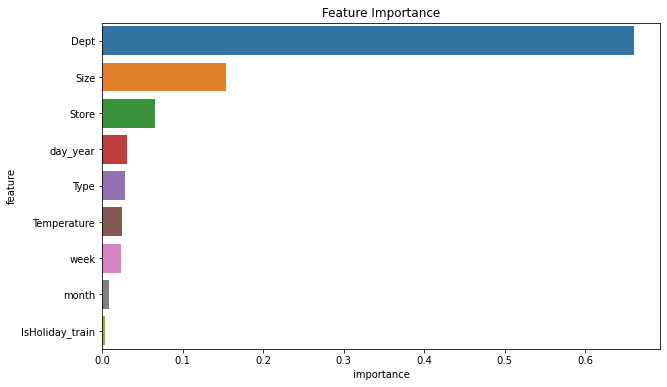

In [94]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df2.head(10), x='importance', y='feature');

# 2.	What features or store attribute is most important in predicting sales? Which one are least?

The most important feature is Dept, followed by size of stores.
The least features or attributes is holidays.